# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [104]:
import numpy as np
import os
# from scipy.misc import imread, imresize deprecated

import imageio
from PIL import Image


import datetime
import os
import math

We set the random seed so that the results don't vary drastically.

In [105]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
import tensorflow as tf
tf.random.set_seed(30)


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
!ls "/content/drive/My Drive/Gesture-Recognition-Project/Project_data/"

train  train.csv  val  val.csv


In [108]:
!ls "/content/drive/My Drive/Gesture-Recognition-Project/Project_data"

train  train.csv  val  val.csv


In [109]:
# Path to train and validation CSV files
train_csv_path = '/content/drive/My Drive/Gesture-Recognition-Project/Project_data/train.csv'
val_csv_path = '/content/drive/My Drive/Gesture-Recognition-Project/Project_data/val.csv'

# Read train.csv and val.csv properly
with open(train_csv_path, 'r') as f:
    train_doc = f.readlines()  # Read each line from CSV

# Clean and remove empty lines
train_doc = [line.strip() for line in train_doc if line.strip()]

# Shuffle the list randomly
train_doc = np.random.permutation(train_doc)

# Print for verification
print("train_doc (first 5):", train_doc[:5])
print("type(train_doc):", type(train_doc))
print("length of train_doc:", len(train_doc))

# Repeat the same for val_doc
with open(val_csv_path, 'r') as f:
    val_doc = f.readlines()

val_doc = [line.strip() for line in val_doc if line.strip()]
val_doc = np.random.permutation(val_doc)

print("val_doc (first 5):", val_doc[:5])
print("type(val_doc):", type(val_doc))
print("length of val_doc:", len(val_doc))


# Properly read train.csv and val.csv
# train_csv_path = '/content/drive/My Drive/Gesture-Recognition-Project/Project_data/train.csv'
# val_csv_path = '/content/drive/My Drive/Gesture-Recognition-Project/Project_data/Collated_training/val.csv'

# # Read CSV contents as lines and clean up
# with open(train_csv_path, 'r') as f:
#     train_doc = f.readlines()

# with open(val_csv_path, 'r') as f:
#     val_doc = f.readlines()

# # Strip newlines and empty entries
# train_doc = [line.strip() for line in train_doc if line.strip()]
# val_doc = [line.strip() for line in val_doc if line.strip()]

# # Shuffle the list randomly
# train_doc = np.random.permutation(train_doc)
# val_doc = np.random.permutation(val_doc)

# # Print for debugging
# print("Train document (first 5):", train_doc[:5])
# print("Validation document (first 5):", val_doc[:5])
# print("Train length:", len(train_doc))
# print("Validation length:", len(val_doc))

# batch_size = 32


# train_doc = '/content/drive/My Drive/Gesture-Recognition-Project/Project_data/train.csv.readlines()'
# val_doc = '/content/drive/My Drive//content/drive/My Drive/Gesture-Recognition-Project/Project_data/Collated_training/val.csv.readlines()'

# # train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv'))
# # val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
# batch_size = 32

# # # Print for debugging
# print("Train document (first 5):", train_doc[:5])
# print("Validation document (first 5):", val_doc[:5])
# print("Train length:", len(train_doc))
# print("Validation length:", len(val_doc))

train_doc (first 5): ['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1'
 'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3'
 'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0'
 'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0']
type(train_doc): <class 'numpy.ndarray'>
length of train_doc: 663
val_doc (first 5): ['WIN_20180926_17_24_20_Pro_Thumbs_Down_new;Thumbs_Down_new;3'
 'WIN_20180907_15_54_30_Pro_Thumbs Up_new;Thumbs Up_new;4'
 'WIN_20180926_17_08_11_Pro_Stop_new;Stop_new;2'
 'WIN_20180925_18_01_40_Pro_Left_Swipe_new;Left_Swipe_new;0'
 'WIN_20180907_16_16_48_Pro_Stop Gesture_new;Stop Gesture_new;2']
type(val_doc): <class 'numpy.ndarray'>
length of val_doc: 100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy. In order to be able to vary the value for img_idx, we will initially set the parameter to be an optional parameter with a default value of even images-  reducing the size for processing, while still retaining a spread of values.

In [110]:
# Example: Calculating the Number of Full Batches and Leftover Items

# if total number of videos to be processed
total_videos = 29

# and if desired number of videos per batch
batch_size = 5

# Use divmod to calculate the number of full batches and the number of leftover videos
num_full_batches, leftover_videos = divmod(total_videos, batch_size)

# Display the results with clear formatting
print(f"Total Videos      : {total_videos}")
print(f"Batch Size        : {batch_size}")
print(f"Full Batches      : {num_full_batches}")
print(f"Leftover Videos   : {leftover_videos}")



Total Videos      : 29
Batch Size        : 5
Full Batches      : 5
Leftover Videos   : 4


In [111]:

def generator(source_path, folder_list, batch_size, img_idx=[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]):
    print('Source path = ', source_path, '; batch size =', batch_size, '; Image Index =', img_idx)
    x = len(img_idx)  # frames per video
    y, z = 80, 80  # Target dimensions for all images

    while True:
        print("folder_list:", folder_list[:5])  # Debug first 5
        print("type(folder_list):", type(folder_list))
        print("length of folder_list:", len(folder_list))

        t = np.random.permutation(folder_list)
        num_batches, leftover_videos = divmod(len(t), batch_size)  # calculate the number of batches

        # ========================
        # Main Loop for Batches
        # ========================
        for batch in range(num_batches):
            print(f"Processing batch {batch + 1}/{num_batches}")
            batch_data = np.zeros((batch_size, x, y, z, 3))  # 5D array for batch
            batch_labels = np.zeros((batch_size, 5))  # One-hot encoded labels

            for folder in range(batch_size):
                folder_name = t[folder + (batch * batch_size)].strip().split(';')[0]
                label = int(t[folder + (batch * batch_size)].strip().split(';')[2])

                folder_path = os.path.join(source_path, folder_name)
                imgs = os.listdir(folder_path)
                print(f"  Folder {folder_name} - {len(imgs)} images found")

                for idx, item in enumerate(img_idx):
                    try:
                        img_path = os.path.join(folder_path, imgs[item])
                        image = imageio.imread(img_path).astype(np.float32)

                        # Resize the image to (y, z) using PIL
                        image_resized = Image.fromarray(image.astype('uint8')).resize((z, y))
                        image_resized = np.array(image_resized)  # Convert back to NumPy array

                        # Normalize and assign resized image
                        batch_data[folder, idx, :, :, 0] = image_resized[..., 0] / 255
                        batch_data[folder, idx, :, :, 1] = image_resized[..., 1] / 255
                        batch_data[folder, idx, :, :, 2] = image_resized[..., 2] / 255

                    except IndexError:
                        print(f"ERROR: img_idx {item} out of range for {folder_name}")
                        continue
                    except Exception as e:
                        print(f"ERROR processing image {img_path}: {e}")
                        raise e

                batch_labels[folder, label] = 1
            yield batch_data, batch_labels

        # ========================
        # Leftover Batch Handling
        # ========================
        if leftover_videos != 0:
            print("Processing leftover videos...")
            batch_data = np.zeros((leftover_videos, x, y, z, 3))
            batch_labels = np.zeros((leftover_videos, 5))

            for i in range(leftover_videos):
                folder_name = t[num_batches * batch_size + i].strip().split(';')[0]
                label = int(t[num_batches * batch_size + i].strip().split(';')[2])

                folder_path = os.path.join(source_path, folder_name)
                imgs = os.listdir(folder_path)

                for idx, item in enumerate(img_idx):
                    try:
                        img_path = os.path.join(folder_path, imgs[item])
                        image = imageio.imread(img_path).astype(np.float32)

                        # Resize the image to (y, z) using PIL
                        image_resized = Image.fromarray(image.astype('uint8')).resize((z, y))
                        image_resized = np.array(image_resized)

                        # Normalize and assign resized image
                        batch_data[i, idx, :, :, 0] = image_resized[..., 0] / 255
                        batch_data[i, idx, :, :, 1] = image_resized[..., 1] / 255
                        batch_data[i, idx, :, :, 2] = image_resized[..., 2] / 255

                    except IndexError:
                        print(f"ERROR: img_idx {item} out of range for {folder_name}")
                        continue
                    except Exception as e:
                        print(f"ERROR processing image {img_path}: {e}")
                        raise e

                batch_labels[i, label] = 1
            yield batch_data, batch_labels

# def generator(source_path, folder_list, batch_size,  img_idx=[2,4,6,8,10,12,14,16,18,20,22,24,26]):
#     print( 'Source path = ', source_path, '; batch size =', batch_size, '; Image Index =', img_idx )
#     x = len(img_idx)  # frames per video
#     y=80
#     z=80


#     while True:
#         print("folder_list:", folder_list)
#         print("type(folder_list):", type(folder_list))
#         print("length of folder_list:", len(folder_list))

#         t = np.random.permutation(folder_list)
#         num_batches, leftover_videos = divmod(len(t), batch_size) # calculate the number of batches
#         for batch in range(num_batches): # we iterate over the number of batches
#             batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
#             batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
#             for folder in range(batch_size): # iterate over the batch_size
#                 imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
#                 for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
#                     image = imageio.imread(source_path + '/' + t[folder + (batch*batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)

#                     #crop the images and resize them. Note that the images are of 2 different shape
#                     #and the conv3D will throw error if the inputs in a batch have different shapes

#                     batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
#                     batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
#                     batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image

#                 batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#             yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


#                 # write the code for the remaining data points which are left after full batches
#         if leftover_videos != 0:  # we iterate over the number of batches
#             # Create exactly one "small batch" for the leftover videos
#             batch_data = np.zeros((leftover_videos, x, y, z, 3))  # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
#             batch_labels = np.zeros((leftover_videos, 5))  # batch_labels is the one hot representation of the output

#             for i in range(leftover_videos):  # iterate over the batch_size
#                 video_index = num_batches * batch_size + i
#                 folder_name = t[video_index].split(';')[0]
#                 label = int(t[video_index].strip().split(';')[2])

#                 imgs = os.listdir(source_path + '/' + folder_name)  # read all the images in the folder
#                 for idx, item in enumerate(img_idx):  #  Iterate iver the frames/images of a folder to read them in
#                     image = imageio.imread(source_path + '/' + t[folder + (batch*batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)


#                     #crop the images and resize them. Note that the images are of 2 different shape
#                     #and the conv3D will throw error if the inputs in a batch have different shapes
#                     batch_data[i, idx, :, :, 0] = image[..., 0] / 255  # normalise and feed in the image
#                     batch_data[i, idx, :, :, 1] = image[..., 1] / 255  # normalise and feed in the image
#                     batch_data[i, idx, :, :, 2] = image[..., 2] / 255  # normalise and feed in the image

#                 batch_labels[i, label] = 1

#             yield batch_data, batch_labels  # you yield the batch_data and the batch_labels, remember what does yield do




Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [112]:
curr_dt_time = datetime.datetime.now()

train_path = '/content/drive/My Drive/Gesture-Recognition-Project/Project_data/train'
val_path = '/content/drive/My Drive/Gesture-Recognition-Project/Project_data/val'

# Check if train and val paths exist
if os.path.exists(train_path):
    print(f"Train path exists: {train_path}")
    print("Files in train path:", os.listdir(train_path))
else:
    print(f"ERROR: Train path does NOT exist: {train_path}")

if os.path.exists(val_path):
    print(f"Validation path exists: {val_path}")
    print("Files in validation path:", os.listdir(val_path))
else:
    print(f"ERROR: Validation path does NOT exist: {val_path}")



# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

Train path exists: /content/drive/My Drive/Gesture-Recognition-Project/Project_data/train
Files in train path: ['WIN_20180907_15_35_09_Pro_Right Swipe_new', 'WIN_20180907_15_38_17_Pro_Left Swipe_new_Left Swipe_new', 'WIN_20180907_15_38_24_Pro_Right Swipe_new', 'WIN_20180907_15_39_51_Pro_Stop Gesture_new', 'WIN_20180907_15_38_35_Pro_Thumbs Down_new', 'WIN_20180907_15_40_55_Pro_Thumbs Up_new', 'WIN_20180907_15_39_54_Pro_Thumbs Up_new', 'WIN_20180907_15_40_26_Pro_Thumbs Down_new', 'WIN_20180907_15_43_00_Pro_Left Swipe_new_Left Swipe_new', 'WIN_20180907_15_43_28_Pro_Right Swipe_new', 'WIN_20180907_15_41_54_Pro_Right Swipe_new', 'WIN_20180907_15_43_40_Pro_Stop Gesture_new', 'WIN_20180907_15_44_13_Pro_Stop Gesture_new', 'WIN_20180907_15_43_58_Pro_Left Swipe_new_Left Swipe_new', 'WIN_20180907_15_45_30_Pro_Thumbs Up_new', 'WIN_20180907_15_44_32_Pro_Thumbs Down_new', 'WIN_20180907_15_44_36_Pro_Right Swipe_new', 'WIN_20180907_15_44_55_Pro_Stop Gesture_new', 'WIN_20180907_15_45_56_Pro_Thumbs Down

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [113]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

# Example hyperparameters:
num_frames = 13          # e.g. len(img_idx)
image_height = 80        # e.g. post-resize or original image height
image_width = 80         # e.g. post-resize or original image width
num_classes = 5          # e.g. gestures = 5

# Build a lightweight 3D CNN
model = Sequential()

# 1st 3D conv block
model.add(Conv3D(16, (3,3,3),
                 input_shape=(num_frames, image_height, image_width, 3),
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# 2nd 3D conv block
model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten + Dense layers
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Final softmax output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with an optimizer of your choice:
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_10 (Conv3D)                   │ (None, 13, 80, 80, 16)      │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 13, 80, 80, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 13, 80, 80, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_10 (MaxPooling3D)      │ (None, 6, 40, 40, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_11 (Conv3D)                   │ (None, 6, 40, 40, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 6, 40, 40, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 6, 40, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_11 (MaxPooling3D)      │ (None, 3, 20, 20, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │       2,457,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,475,653 (9.44 MB)

 Trainable params: 2,475,365 (9.44 MB)

 Non-trainable params: 288 (1.12 KB)

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [114]:
optimiser = optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_10 (Conv3D)                   │ (None, 13, 80, 80, 16)      │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 13, 80, 80, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 13, 80, 80, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_10 (MaxPooling3D)      │ (None, 6, 40, 40, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_11 (Conv3D)                   │ (None, 6, 40, 40, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 6, 40, 40, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 6, 40, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_11 (MaxPooling3D)      │ (None, 3, 20, 20, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │       2,457,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,475,653 (9.44 MB)

 Trainable params: 2,475,365 (9.44 MB)

 Non-trainable params: 288 (1.12 KB)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [115]:
print(train_path)
print(train_doc)
print(batch_size)

/content/drive/My Drive/Gesture-Recognition-Project/Project_data/train
['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1'
 'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3'
 'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0'
 'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0'
 'WIN_20180926_17_30_47_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180926_17_29_23_Pro_Stop_new;Stop_new;2'
 'WIN_20180926_17_12_26_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180926_17_29_01_Pro_Stop_new;Stop_new;2'
 'WIN_20180907_16_32_11_Pro_Stop Gesture_new;Stop Gesture_new;2'
 'WIN_20180926_17_06_01_Pro_Stop_new;Stop_new;2'
 'WIN_20180907_16_52_18_Pro_Stop Gesture_new;Stop Gesture_new;2'
 'WIN_20180907_16_39_19_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0'
 'WIN_20180925_17_19_16_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180907_16_19_10_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left

In [116]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [117]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'  # saves at the end of every epoch
)


LR = ReduceLROnPlateau(
    monitor='val_loss',   # metric to watch
    factor=0.1,           # factor by which the learning rate will be reduced
    patience=4,           # number of epochs with no improvement after which learning rate will be reduced
    verbose=1,            # verbosity (1 = update messages)
    mode='auto',          # can be 'min', 'max', or 'auto'
    cooldown=0,           # number of epochs to wait before resuming normal operation after lr has been reduced
    min_lr=1e-5           # lower bound on the learning rate
)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [118]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [119]:
print("Length of train_doc:", len(train_doc))
print("Steps_per_epoch :", steps_per_epoch )


Length of train_doc: 663
Steps_per_epoch : 133


In [120]:
batch_data, batch_labels = next(train_generator)
print("Batch data shape:", batch_data.shape)
print("Batch labels shape:", batch_labels.shape)


Source path =  /content/drive/My Drive/Gesture-Recognition-Project/Project_data/train ; batch size = 5 ; Image Index = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
folder_list: ['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1'
 'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3'
 'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0'
 'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0']
type(folder_list): <class 'numpy.ndarray'>
length of folder_list: 663
Processing batch 1/132
  Folder WIN_20180926_17_24_58_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180926_17_35_17_Pro_Stop_new - 30 images found


<ipython-input-111-7905c8aaaac9>:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


  Folder WIN_20180925_17_58_10_Pro_Stop_new - 30 images found
  Folder WIN_20180925_17_20_16_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180926_16_58_12_Pro_Left_Swipe_new - 30 images found
Batch data shape: (5, 13, 80, 80, 3)
Batch labels shape: (5, 5)


In [121]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    initial_epoch=0
)



Processing batch 2/132
  Folder WIN_20180926_17_33_51_Pro_Thumbs_Up_new - 30 images found


<ipython-input-111-7905c8aaaac9>:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


  Folder WIN_20180925_17_22_11_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180926_16_49_15_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180925_18_14_35_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180925_18_01_30_Pro_Stop_new - 30 images found
Processing batch 3/132
  Folder WIN_20180925_17_31_02_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180907_16_05_08_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180925_17_57_22_Pro_Stop_new - 30 images found
  Folder WIN_20180926_16_58_27_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180926_16_52_43_Pro_Thumbs_Down_new - 30 images found
Epoch 1/20
  1/133 ━━━━━━━━━━━━━━━━━━━━ 15:00 7s/step - categorical_accuracy: 0.2000 - loss: 1.7811Processing batch 4/132
  Folder WIN_20180907_15_59_44_Pro_Right Swipe_new - 30 images found
  Folder WIN_20180925_17_36_07_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180926_17_24_33_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180907_15_48_01_Pro_Stop Gestu

<ipython-input-111-7905c8aaaac9>:72: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


Streaming output truncated to the last 5000 lines.
  Folder WIN_20180926_16_55_03_Pro_Stop_new - 30 images found
  Folder WIN_20180925_17_39_25_Pro_Left_Swipe_new - 30 images found
Processing batch 82/132
  Folder WIN_20180926_17_45_57_Pro_Thumbs_Down_new - 30 images found
 80/133 ━━━━━━━━━━━━━━━━━━━━ 20s 388ms/step - categorical_accuracy: 0.6268 - loss: 0.9360  Folder WIN_20180925_18_28_41_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180926_17_25_32_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180907_16_56_18_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180926_17_40_37_Pro_Stop_new - 30 images found
Processing batch 83/132
  Folder WIN_20180907_15_55_27_Pro_Thumbs Down_new - 30 images found
 81/133 ━━━━━━━━━━━━━━━━━━━━ 20s 388ms/step - categorical_accuracy: 0.6262 - loss: 0.9371  Folder WIN_20180925_17_28_48_Pro_Stop_new - 30 images found
  Folder WIN_20180926_17_13_59_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180907_16_19_31_Pro_Right Swipe_new - 30

In [122]:
final_loss, final_accuracy = model.evaluate(val_generator, steps=validation_steps)
print("Final Validation Loss:", final_loss)
print("Final Validation Accuracy:", final_accuracy)


Processing batch 14/20
  Folder WIN_20180907_15_55_06_Pro_Right Swipe_new - 30 images found
  Folder WIN_20180925_17_58_08_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180926_16_57_50_Pro_Thumbs_Down_new - 30 images found


<ipython-input-111-7905c8aaaac9>:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


  Folder WIN_20180926_17_04_53_Pro_Stop_new - 30 images found
  Folder WIN_20180926_17_34_23_Pro_Thumbs_Down_new - 30 images found
Processing batch 15/20
  Folder WIN_20180925_17_48_16_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180907_15_42_17_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180926_16_46_22_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180926_16_37_56_Pro_Stop_new - 30 images found
  Folder WIN_20180907_16_00_42_Pro_Left Swipe_new_Left Swipe_new - 30 images found
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 1.0000 - loss: 0.3146Processing batch 16/20
  Folder WIN_20180926_17_24_20_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180926_17_33_14_Pro_Stop_new - 30 images found
  Folder WIN_20180926_17_33_14_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180926_17_33_49_Pro_Stop_new - 30 images found
  Folder WIN_20180907_16_31_41_Pro_Stop Gesture_new - 30 images found
Processing batch 17/20
  Folder WIN_20180907_15_30_06_

In [123]:

print("Total Params:", model.count_params())

Total Params: 2475653


# Model 2: CNN + RNN Model (GRU)

In [124]:
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten
from keras.layers import GRU, Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import SGD

# Hyperparameters
num_frames = 13          # same as before, len(img_idx)
image_height = 80        # same image dimensions used in your dataset
image_width = 80
num_classes = 5
rnn_units = 32           # number of GRU units (tweak as needed)

# Build the CNN + RNN model
model2 = Sequential()

# 1) TimeDistributed CNN Block
#    Applies a 2D CNN to each frame in the sequence.
model2.add(TimeDistributed(
    Conv2D(16, (3,3), padding='same', activation='relu'),
    input_shape=(num_frames, image_height, image_width, 3)
))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

# 2) Another TimeDistributed CNN Block (optional, to increase capacity)
model2.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

# 3) Flatten the CNN output per frame
model2.add(TimeDistributed(Flatten()))

# 4) RNN Layer (GRU or LSTM)
model2.add(GRU(rnn_units, return_sequences=False))
# If you want to stack RNNs or keep sequence output, adjust return_sequences.

# 5) Dense + Dropout + BN
model2.add(Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

model2.add(Dense(32, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

# 6) Final Output Layer
model2.add(Dense(num_classes, activation='softmax'))

# Compile
optimiser = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model2.compile(
    optimizer=optimiser,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

model2.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 13, 80, 80, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 13, 80, 80, 16)      │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 13, 40, 40, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 13, 40, 40, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 13, 40, 40, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 13, 20, 20, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 13, 12800)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 32)                  │       1,232,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,242,085 (4.74 MB)

 Trainable params: 1,241,797 (4.74 MB)

 Non-trainable params: 288 (1.12 KB)

In [125]:
# For the same dataset/generator:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

# Same callbacks, e.g.
callbacks_list = [checkpoint, LR]  # define your ModelCheckpoint, ReduceLROnPlateau, etc.

history2 = model2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    initial_epoch=0
)


Source path =  /content/drive/My Drive/Gesture-Recognition-Project/Project_data/train ; batch size = 5 ; Image Index = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
folder_list: ['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1'
 'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3'
 'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0'
 'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0']
type(folder_list): <class 'numpy.ndarray'>
length of folder_list: 663
Processing batch 1/132
  Folder WIN_20180926_17_52_26_Pro_Stop_new - 30 images found
  Folder WIN_20180926_17_04_58_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180926_17_23_23_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180926_17_45_57_Pro_Thumbs_Down_new - 30 images found


<ipython-input-111-7905c8aaaac9>:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


  Folder WIN_20180907_16_12_20_Pro_Right Swipe_new - 30 images found
Processing batch 2/132
  Folder WIN_20180907_16_32_11_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180925_17_29_52_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180925_17_40_22_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180926_17_39_59_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180925_18_02_41_Pro_Right_Swipe_new - 30 images found
Epoch 1/20
  1/133 ━━━━━━━━━━━━━━━━━━━━ 23:09 11s/step - categorical_accuracy: 0.2000 - loss: 1.6901Processing batch 3/132
  Folder WIN_20180926_16_39_58_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180907_15_49_56_Pro_Right Swipe_new - 30 images found
  Folder WIN_20180926_16_40_38_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180925_18_26_40_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180907_16_05_58_Pro_Stop Gesture_new - 30 images found
Processing batch 4/132
  Folder WIN_20180907_15_48_25_Pro_Thumbs Down_new - 30 images found
  

<ipython-input-111-7905c8aaaac9>:72: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


Streaming output truncated to the last 5000 lines.
  Folder WIN_20180907_16_37_22_Pro_Thumbs Up_new - 30 images found
  Folder WIN_20180926_17_01_50_Pro_Stop_new - 30 images found
Processing batch 81/132
  Folder WIN_20180925_17_55_45_Pro_Thumbs_Down_new - 30 images found
 80/133 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - categorical_accuracy: 0.1789 - loss: 1.6321  Folder WIN_20180925_17_37_42_Pro_Stop_new - 30 images found
  Folder WIN_20180907_15_54_06_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180907_16_25_52_Pro_Thumbs Down_new - 30 images found
  Folder WIN_20180925_17_46_49_Pro_Left_Swipe_new - 30 images found
Processing batch 82/132
  Folder WIN_20180907_15_53_12_Pro_Thumbs Up_new - 30 images found
 81/133 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - categorical_accuracy: 0.1788 - loss: 1.6320  Folder WIN_20180926_17_35_54_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180925_18_12_58_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180907_16_17_11_Pro_Left Swipe_new_Lef

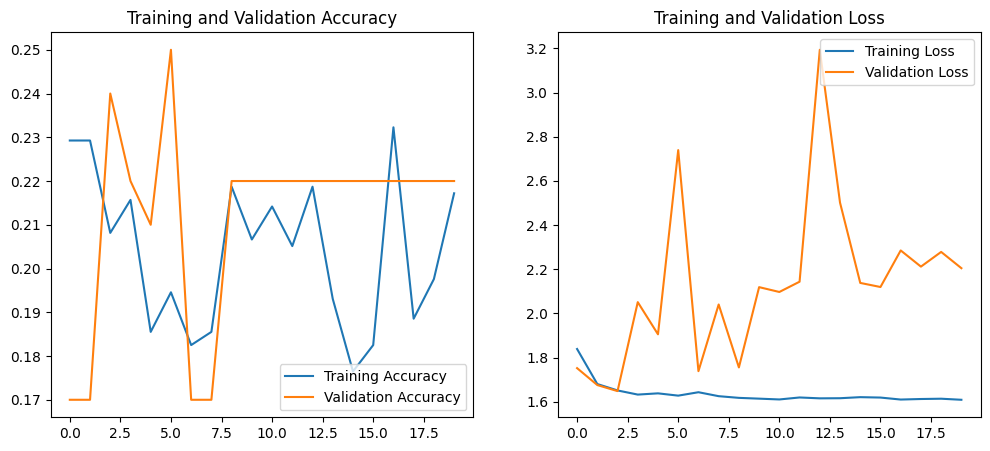

In [126]:
import matplotlib.pyplot as plt

# Extract metrics from history2
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Determine how many epochs were actually run
epochs_range = range(len(acc))

# Plotting
plt.figure(figsize=(12, 5))

# ---------------------------
# Subplot 1: Accuracy
# ---------------------------
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# ---------------------------
# Subplot 2: Loss
# ---------------------------
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
final_loss, final_accuracy = model2.evaluate(val_generator, steps=validation_steps)
print("Final Validation Loss:", final_loss)
print("Final Validation Accuracy:", final_accuracy)

Processing batch 15/20
  Folder WIN_20180926_16_48_48_Pro_Stop_new - 30 images found
  Folder WIN_20180926_16_44_04_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180926_17_05_38_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180907_16_36_42_Pro_Left Swipe_new_Left Swipe_new - 30 images found


<ipython-input-111-7905c8aaaac9>:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


In [129]:
print("Total Params:", model2.count_params())

Total Params: 1242085
